### Importar los modules requeridos


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Para la regresión y validación de supuestos llamamos a statsmodel, el módulo encargado de la notación de fórmula y al módulo para las pruebas de hipótesis.

In [2]:
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.compat import lzip

### 1. Importar una base al Jupyter Notebook con pandas

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Leer base de datos con pandas

file_path = "/content/drive/MyDrive/UDLA-Analitica predictiva/dataset.csv"
df = pd.read_csv(file_path)
df

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181
...,...,...,...,...,...
4567,26.0,4.472360,0.717090,Micro,94.685866
4568,71.0,20.610685,6.545573,Nano,249.101915
4569,44.0,19.800072,5.096192,Micro,163.631457
4570,71.0,17.534640,1.940873,Macro,253.610411


# OPCIÓN 1: LOW-CODE Y RÉPLICA DE NOTEBOOK

### 2. Descriptivos

In [7]:
df.describe()

,TV,Radio,Social Media,Sales
count,4562.000000,4568.000000,4566.000000,4566.000000
mean,54.066857,18.160356,3.323956,192.466602
std,26.125054,9.676958,2.212670,93.133092
min,10.000000,0.000684,0.000031,31.199409
25%,32.000000,10.525957,1.527849,112.322882
50%,53.000000,17.859513,3.055565,189.231172
75%,77.000000,25.649730,4.807558,272.507922
max,100.000000,48.871161,13.981662,364.079751


In [8]:
df.describe(include = 'object')

,Influencer
count,4572
unique,4
top,Mega
freq,1158


### 3. Datos Perdidos

In [9]:
df.isna().sum()

TV              10
Radio            4
Social Media     6
Influencer       0
Sales            6
dtype: int64

4. Evaluación de Datos Atípicos (Outliers)

In [10]:

# Identificación de valores atípicos (outliers)
valores_atipicos = {}

variables_numericas = df.select_dtypes(include=['number']).columns

for columna in variables_numericas:
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    valores_atipicos[columna] = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)][columna].count()
print("Valores Atípicos:\n", valores_atipicos)


Valores Atípicos:
 {'TV': 0, 'Radio': 1, 'Social Media': 28, 'Sales': 0}


4.1  Corrección de Datos Perdidos y Atípicos

In [11]:
# Imputar valores perdidos con la mediana
for columna in variables_numericas:
    valor_mediana = df[columna].median()
    df[columna].fillna(valor_mediana, inplace=True)

# Aplicar winsorización para tratar los valores atípicos (outliers)
from scipy.stats.mstats import winsorize

df['Radio'] = winsorize(df['Radio'], limits=[0.01, 0.01])
df['Redes Sociales'] = winsorize(df['Social Media'], limits=[0.01, 0.01])

# Verificar nuevamente los datos perdidos y valores atípicos
datos_perdidos_despues = df.isnull().sum()
valores_atipicos_despues = {}
for columna in variables_numericas:
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    valores_atipicos_despues[columna] = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)][columna].count()

print("Datos Perdidos Después de la Corrección:\n", datos_perdidos_despues)
print("Valores Atípicos Después de la Corrección:\n", valores_atipicos_despues)


Datos Perdidos Después de la Corrección:
 TV                0
Radio             0
Social Media      0
Influencer        0
Sales             0
Redes Sociales    0
dtype: int64
Valores Atípicos Después de la Corrección:
 {'TV': 0, 'Radio': 0, 'Social Media': 28, 'Sales': 0}


5.Visualización de Distribuciones

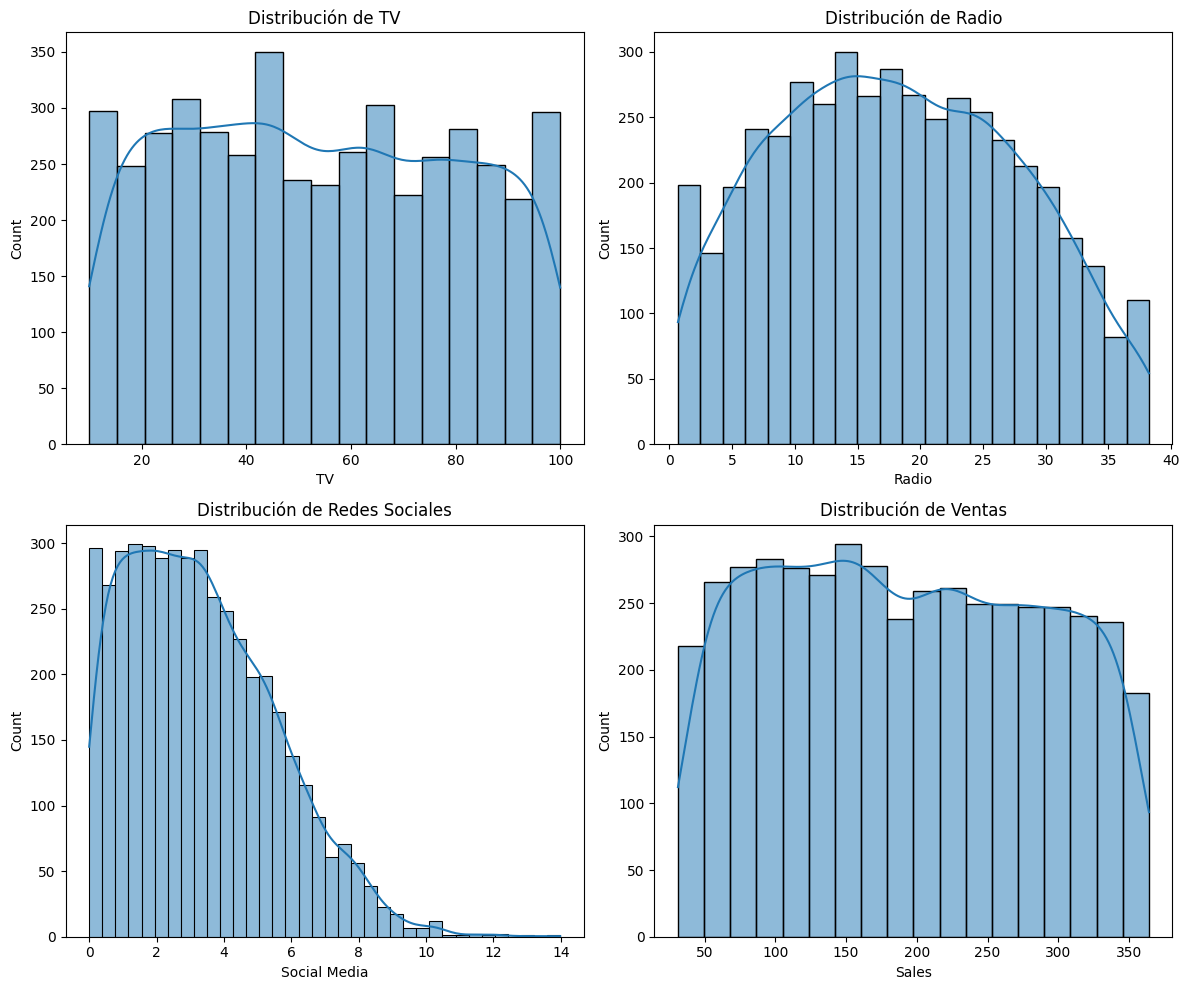

In [12]:

# Graficar distribuciones de las variables numéricas
figura, ejes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(df['TV'], kde=True, ax=ejes[0, 0])
ejes[0, 0].set_title('Distribución de TV')

sns.histplot(df['Radio'], kde=True, ax=ejes[0, 1])
ejes[0, 1].set_title('Distribución de Radio')

sns.histplot(df['Social Media'], kde=True, ax=ejes[1, 0])
ejes[1, 0].set_title('Distribución de Redes Sociales')

sns.histplot(df['Sales'], kde=True, ax=ejes[1, 1])
ejes[1, 1].set_title('Distribución de Ventas')

plt.tight_layout()
plt.show()


6. Correlaciones entre Variables Numéricas

In [13]:
columnas_seleccionadas = ['TV', 'Radio', 'Social Media', 'Sales']

# Seleccionar solo las columnas numéricas deseadas
numeric_df = df[columnas_seleccionadas]
correlacion= numeric_df.corr().style.background_gradient(cmap='coolwarm')
correlacion

,TV,Radio,Social Media,Sales
TV,1.000000,0.868052,0.526966,0.996636
Radio,0.868052,1.000000,0.606121,0.868563
Social Media,0.526966,0.606121,1.000000,0.528116
Sales,0.996636,0.868563,0.528116,1.000000


7.Variables Independientes y Dependientes

In [14]:
# Mostrar las primeras filas del DataFrame
print(df.head(5))

     TV      Radio  Social Media Influencer       Sales  Redes Sociales
0  16.0   6.566231      2.907983       Mega   54.732757        2.907983
1  13.0   9.237765      2.409567       Mega   46.677897        2.409567
2  41.0  15.886446      2.913410       Mega  150.177829        2.913410
3  83.0  30.020028      6.922304       Mega  298.246340        6.922304
4  15.0   8.437408      1.405998      Micro   56.594181        1.405998


In [15]:
# Información general del DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TV              4572 non-null   float64
 1   Radio           4572 non-null   float64
 2   Social Media    4572 non-null   float64
 3   Influencer      4572 non-null   object 
 4   Sales           4572 non-null   float64
 5   Redes Sociales  4572 non-null   float64
dtypes: float64(5), object(1)
memory usage: 214.4+ KB
None


In [16]:
# Descripción estadística de las variables numéricas
print(df.describe())

                TV        Radio  Social Media        Sales  Redes Sociales
count  4572.000000  4572.000000   4572.000000  4572.000000     4572.000000
mean     54.064523    18.138154      3.323604   192.462356        3.312630
std      26.096509     9.605922      2.211239    93.072021        2.176020
min      10.000000     0.675874      0.000031    31.199409        0.046325
25%      32.000000    10.546519      1.529879   112.397660        1.529879
50%      53.000000    17.859513      3.055565   189.231172        3.055565
75%      77.000000    25.647476      4.805832   272.414914        4.805832
max     100.000000    38.242728     13.981662   364.079751        9.072549


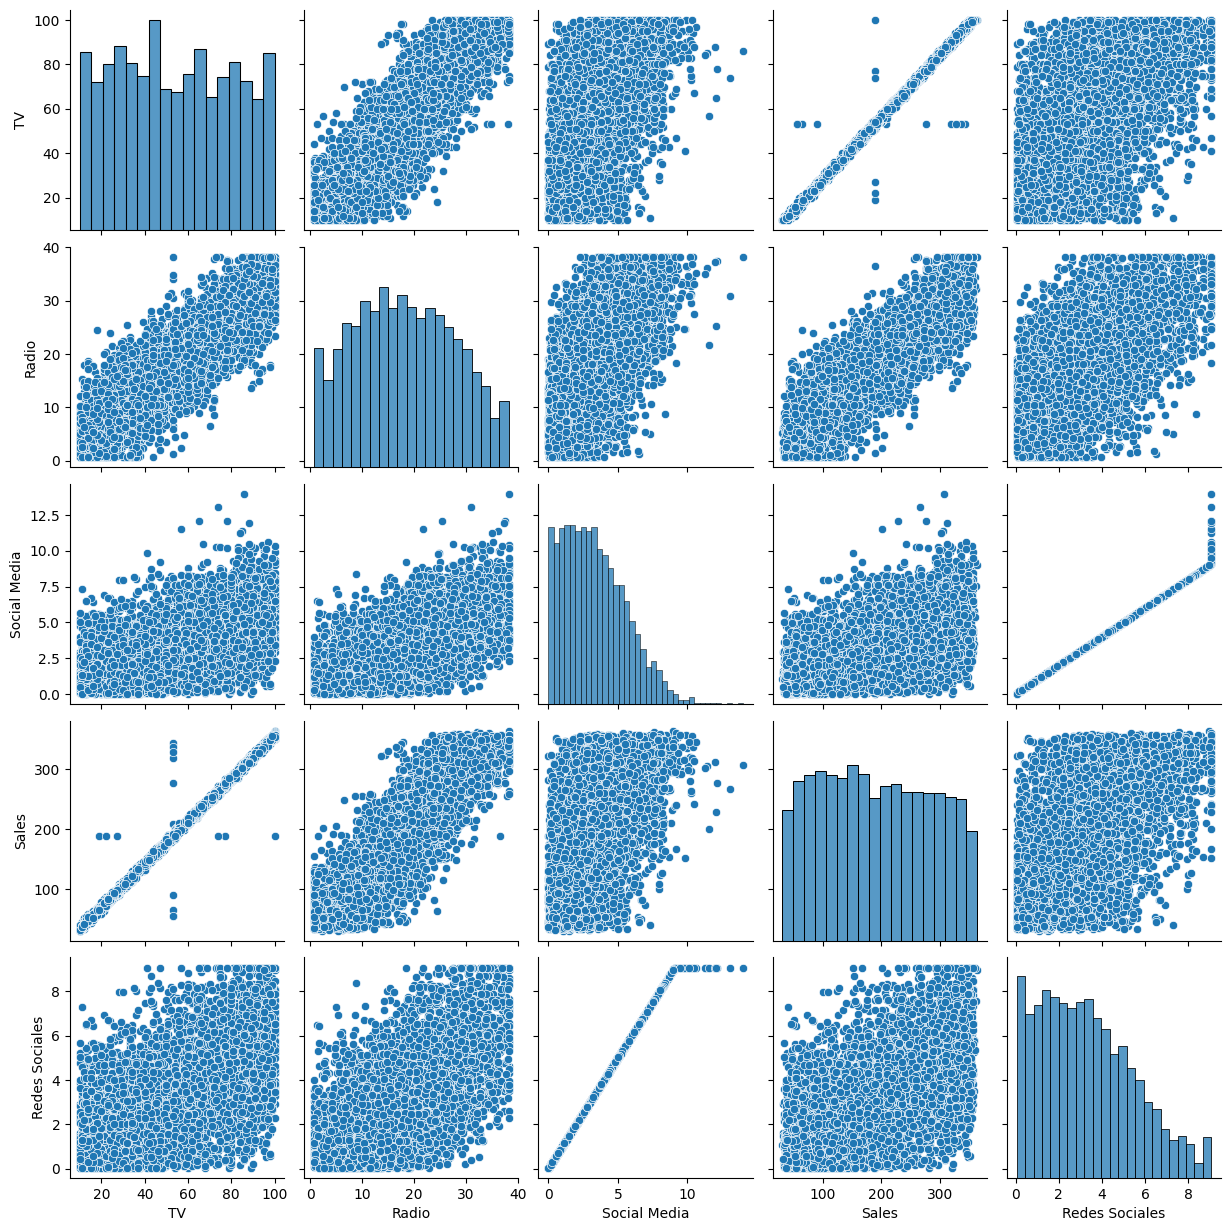

In [17]:
# Visualizar la relación entre posibles variables independientes (X) y la variable dependiente (Y)
sns.pairplot(df)
plt.show()

In [18]:
dependent_var = 'Sales'

In [19]:
independent_vars = ['TV', 'Radio', 'Social Media']

In [20]:
X = df[independent_vars]
y = df[dependent_var]

La variable dependiente es la que queremos predecir. En este caso, es razonable elegir Sales como la variable dependiente.
Las variables independientes X1...Xn son aquellas que usamos para predecir la variable dependiente. Basado en el problema, podemos elegir las siguientes variables:

TV: Gasto en publicidad en televisión.
Radio: Gasto en publicidad en radio.
Social Media: Gasto en publicidad en redes sociales.
Estas variables son lógicas para predecir las ventas, ya que el gasto en publicidad en diferentes medios puede tener un impacto directo en las ventas.


8.MODELO REGRESION

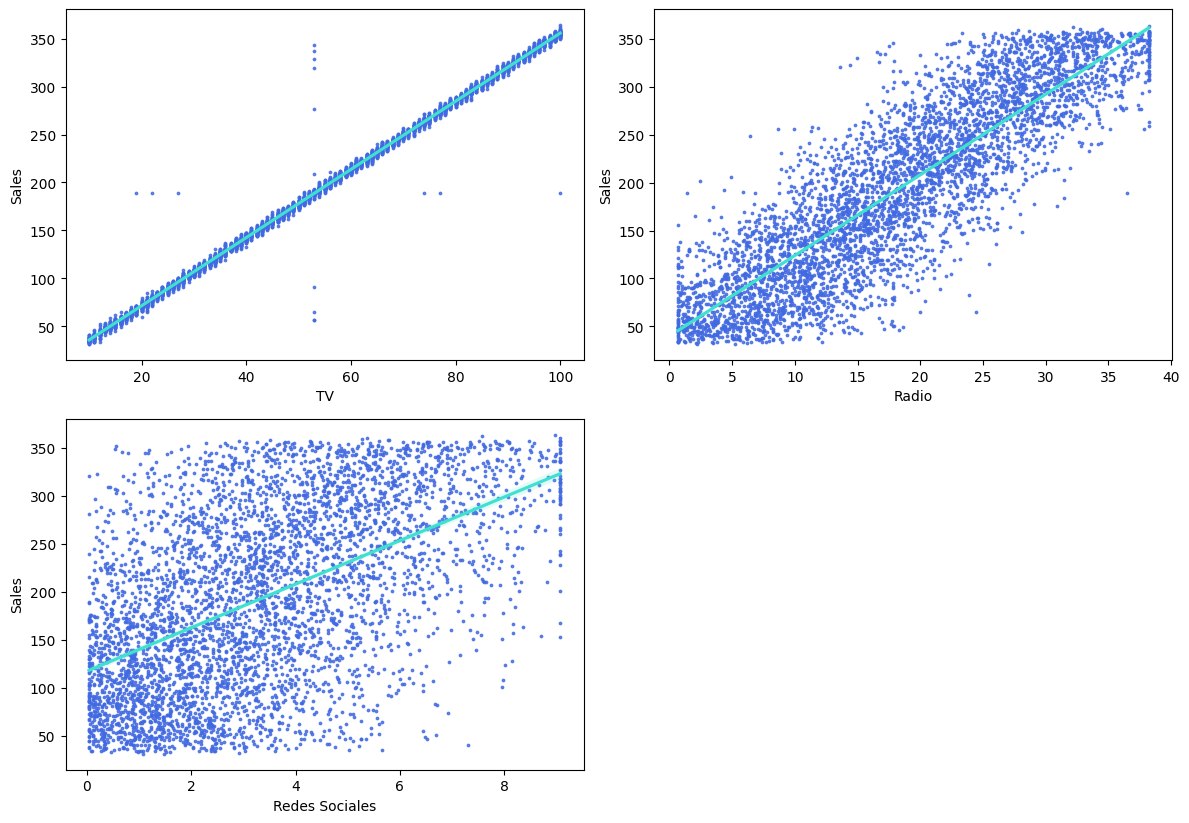

In [21]:
# Número de las variables
n = 4
fig = plt.figure(figsize=(12,12))
# Correlaciones en pares
numerical_df = df.select_dtypes(include=['float64', 'int64'])
corr = numerical_df.corr()
#
cols = corr.nlargest(4, "Sales")["Sales"].index
# Calculate correlation
for i in np.arange(1,4):
    regline = df[cols[i]]
    ax = fig.add_subplot(3,2,i)
    sns.regplot(x=regline, y=df['Sales'], scatter_kws={"color": "royalblue", "s": 3},
                line_kws={"color": "turquoise"})
plt.tight_layout()
plt.show()

In [22]:
log_Sales=np.log(df.Sales)
df['log_Sales']=log_Sales

In [23]:
var_cuantitativas = df.select_dtypes('number').columns
var_cualitativas  =df.select_dtypes('object').columns

In [24]:
df[var_cualitativas]

,Influencer
0,Mega
1,Mega
2,Mega
3,Mega
4,Micro
...,...
4567,Micro
4568,Nano
4569,Micro
4570,Macro


In [25]:
df

,TV,Radio,Social Media,Influencer,Sales,Redes Sociales,log_Sales
0,16.0,6.566231,2.907983,Mega,54.732757,2.907983,4.002462
1,13.0,9.237765,2.409567,Mega,46.677897,2.409567,3.843271
2,41.0,15.886446,2.913410,Mega,150.177829,2.913410,5.011820
3,83.0,30.020028,6.922304,Mega,298.246340,6.922304,5.697920
4,15.0,8.437408,1.405998,Micro,56.594181,1.405998,4.035906
...,...,...,...,...,...,...,...
4567,26.0,4.472360,0.717090,Micro,94.685866,0.717090,4.550565
4568,71.0,20.610685,6.545573,Nano,249.101915,6.545573,5.517862
4569,44.0,19.800072,5.096192,Micro,163.631457,5.096192,5.097617
4570,71.0,17.534640,1.940873,Macro,253.610411,1.940873,5.535799


In [26]:
from sklearn.preprocessing import LabelEncoder

In [27]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

In [28]:
df.Influencer = labelencoder.fit_transform(df.Influencer)
df

,TV,Radio,Social Media,Influencer,Sales,Redes Sociales,log_Sales
0,16.0,6.566231,2.907983,1,54.732757,2.907983,4.002462
1,13.0,9.237765,2.409567,1,46.677897,2.409567,3.843271
2,41.0,15.886446,2.913410,1,150.177829,2.913410,5.011820
3,83.0,30.020028,6.922304,1,298.246340,6.922304,5.697920
4,15.0,8.437408,1.405998,2,56.594181,1.405998,4.035906
...,...,...,...,...,...,...,...
4567,26.0,4.472360,0.717090,2,94.685866,0.717090,4.550565
4568,71.0,20.610685,6.545573,3,249.101915,6.545573,5.517862
4569,44.0,19.800072,5.096192,2,163.631457,5.096192,5.097617
4570,71.0,17.534640,1.940873,0,253.610411,1.940873,5.535799


In [29]:
df.head(3)

,TV,Radio,Social Media,Influencer,Sales,Redes Sociales,log_Sales
0,16.0,6.566231,2.907983,1,54.732757,2.907983,4.002462
1,13.0,9.237765,2.409567,1,46.677897,2.409567,3.843271
2,41.0,15.886446,2.913410,1,150.177829,2.913410,5.011820


In [44]:
df.isna().sum()

TV                0
Radio             0
Social Media      0
Influencer        0
Sales             0
Redes Sociales    0
log_Sales         0
dtype: int64

In [34]:
df[var_cualitativas].astype("object")

,Influencer
0,1
1,1
2,1
3,1
4,2
...,...
4567,2
4568,3
4569,2
4570,0


In [31]:
from sklearn.model_selection import train_test_split

In [37]:
df.head()

,TV,Radio,Social Media,Influencer,Sales,Redes Sociales,log_Sales
0,16.0,6.566231,2.907983,1,54.732757,2.907983,4.002462
1,13.0,9.237765,2.409567,1,46.677897,2.409567,3.843271
2,41.0,15.886446,2.913410,1,150.177829,2.913410,5.011820
3,83.0,30.020028,6.922304,1,298.246340,6.922304,5.697920
4,15.0,8.437408,1.405998,2,56.594181,1.405998,4.035906


In [59]:
df["Influencer"]=df["Influencer"].astype("object")

In [54]:
df["Influencer"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4572 entries, 0 to 4571
Series name: Influencer
Non-Null Count  Dtype
--------------  -----
4572 non-null   int64
dtypes: int64(1)
memory usage: 35.8 KB


In [47]:
df = df.rename(columns={'Redes Sociales': 'Redes_Sociales'})

In [60]:
regresion = ols("log_Sales ~ TV + Radio + Redes_Sociales + Influencer", data=df)
results = regresion.fit()

In [61]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_Sales   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     8627.
Date:                Sat, 13 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:43:54   Log-Likelihood:                 1631.0
No. Observations:                4572   AIC:                            -3248.
Df Residuals:                    4565   BIC:                            -3203.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.9351      0.007    5

# OPCIÓN 2: REPORTE EJECUTIVO PARA GERENCIA 

Elabore una presentación ejecutiva discutiendo las figuras y tablas anteriores, de la Opción Low Code, así como las figuras al final del notebook. 